In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from fuzzywuzzy import process
import re
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Normalization
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text.strip())


def eliminate_double_characters(text):
    # Initialize an empty string to store the processed text
    processed_text = ""
    
    # Iterate through the characters of the input text
    i = 0
    while i < len(text):
        # Append the current character to the processed text
        processed_text += text[i]
        
        # Check if the current character is repeated consecutively
        if i + 1 < len(text) and text[i] == text[i + 1]:
            # Move to the next character skipping the consecutive duplicates
            while i + 1 < len(text) and text[i] == text[i + 1]:
                i += 1
        # Move to the next character
        i += 1
    
    return processed_text


def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def closest_word(text, dataset_texts):
    highest_similarity_score = 0
    closest_match = None
    for word in text.split():
        closest_match_for_word, similarity_score = process.extractOne(word, dataset_texts)
        if similarity_score > highest_similarity_score:
            highest_similarity_score = similarity_score
            closest_match = closest_match_for_word
    return closest_match, highest_similarity_score

def preprocess(df, dataset_texts):
    df['Deskripsi'] = df['Deskripsi'].apply(remove_extra_spaces)
    df['Deskripsi'] = df['Deskripsi'].apply(normalize_text)
    df['Deskripsi'] = df['Deskripsi'].apply(eliminate_double_characters)
    
    closest_words = []
    closest_words_num = []
    closest_words_score = []
    for sentence in df['Deskripsi']:
        closest_match, similarity_score = closest_word(sentence, dataset_texts)
        if similarity_score < 20:
            closest_word_num = 0
            closest_match = "missing"
        else:
            closest_word_num = dataset_texts.index(closest_match) + 1
        closest_words.append(closest_match)
        closest_words_num.append(closest_word_num)
        closest_words_score.append(similarity_score)
    
    df['closest_words'] = closest_words
    df['closest_words_num'] = closest_words_num
    df['score'] = closest_words_score
    
    return df

2024-04-12 17:42:37.581475: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 17:42:37.640918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 17:42:37.640960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 17:42:37.642423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 17:42:37.651408: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 17:42:37.652119: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load the DataFrame
df = pd.read_csv('dummy2.csv')

# Example dataset_texts
dataset_texts = ["shf", "settlement", "fidusia", "pinalty", "umk"]

# Preprocess the data
df = preprocess(df, dataset_texts)

In [3]:
target = df.pop('Verifikasi')

In [4]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

In [5]:
numeric_feature_names = ['closest_words_num', 'Nominal']
numeric_features = df[numeric_feature_names]
numeric_features = tf.convert_to_tensor(numeric_features)

In [6]:
numeric_feature_name = ['closest_words_num']
numeric_features_one = df[numeric_feature_name]
numeric_features_one = tf.convert_to_tensor(numeric_features_one)

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)


In [8]:
horsepower = np.array(numeric_features_one)

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [9]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(16, activation='relu'),
        Dense(64, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')

    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.01),
                  metrics=['accuracy'])
    return model

In [10]:
model = build_and_compile_model(normalizer)

In [11]:
#model.fit(numeric_features, target, epochs=100, batch_size=8)

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath="./",
    monitor='val_accuracy',
    save_best_only=True,  # Save only the best model weights
    verbose=1  # Verbosity mode. Set to 1 to see the messages.
)

In [13]:
%%time        Dense(64, activation='relu'),
history = model.fit(
    numeric_features,
    target_encoded,
    epochs=150,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    callbacks=[checkpoint_callback])


Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to ./
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets



Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy improved from 0.00000 to 0.04762, saving model to ./
INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets



Epoch 5: val_accuracy did not improve from 0.04762

Epoch 6: val_accuracy did not improve from 0.04762

Epoch 7: val_accuracy did not improve from 0.04762

Epoch 8: val_accuracy did not improve from 0.04762

Epoch 9: val_accuracy did not improve from 0.04762

Epoch 10: val_accuracy did not improve from 0.04762

Epoch 11: val_accuracy did not improve from 0.04762

Epoch 12: val_accuracy did not improve from 0.04762

Epoch 13: val_accuracy did not improve from 0.04762

Epoch 14: val_accuracy did not improve from 0.04762

Epoch 15: val_accuracy did not improve from 0.04762

Epoch 16: val_accuracy did not improve from 0.04762

Epoch 17: val_accuracy did not improve from 0.04762

Epoch 18: val_accuracy did not improve from 0.04762

Epoch 19: val_accuracy did not improve from 0.04762

Epoch 20: val_accuracy did not improve from 0.04762

Epoch 21: val_accuracy did not improve from 0.04762

Epoch 22: val_accuracy did not improve from 0.04762

Epoch 23: val_accuracy did not improve from 0.0476

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
145,0.266207,0.927711,16.350382,0.047619,145
146,0.262595,0.915663,16.841038,0.047619,146
147,0.273201,0.903614,16.659012,0.047619,147
148,0.308795,0.867470,16.936939,0.047619,148
149,0.298608,0.885542,16.700518,0.047619,149


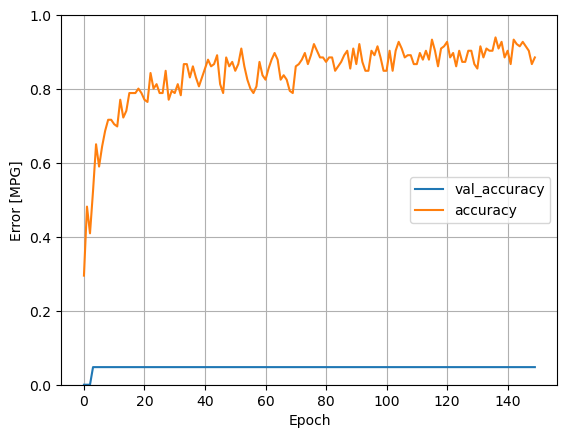

In [15]:
def plot_loss(history):
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [16]:
specific_rows = hist.iloc[13:]
specific_rows

,loss,accuracy,val_loss,val_accuracy,epoch
13,0.691627,0.722892,4.717120,0.047619,13
14,0.643811,0.740964,4.681221,0.047619,14
15,0.608227,0.789157,5.175148,0.047619,15
16,0.622524,0.789157,5.314790,0.047619,16
17,0.584092,0.789157,5.594664,0.047619,17
...,...,...,...,...,...
145,0.266207,0.927711,16.350382,0.047619,145
146,0.262595,0.915663,16.841038,0.047619,146
147,0.273201,0.903614,16.659012,0.047619,147
148,0.308795,0.867470,16.936939,0.047619,148


In [51]:
def preprocess_input(deskripsi, nominal, dataset_texts):
    # Normalize deskripsi
    deskripsi = remove_extra_spaces(deskripsi)
    deskripsi = normalize_text(deskripsi)
    
    # Find the closest word and its number
    closest_match, _ = closest_word(deskripsi, dataset_texts)
    closest_word_num = dataset_texts.index(closest_match) + 1 if closest_match else 0
    
    # Normalize nominal
    nominal = nominal   # Assuming your training data was also scaled
    
    return np.array([[closest_word_num, nominal]], dtype=np.float32)

# Example input
deskripsi = "abcabcabc"
nominal = 450000

# Preprocess input
input_data = preprocess_input(deskripsi, nominal, dataset_texts)


In [52]:
# Predict using the model
predictions = model.predict(input_data)

# Decode the predicted labels
predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])

print("Predicted label:", predicted_label)


1/1 [==============================] - 0s 32ms/step
Predicted label: ['Fidusia']
